**Snapshots**: https://www.tng-project.org/data/downloads/TNG300-1/

In [104]:
import numpy as np 

import pickle

import pandas as pd


import multicam

from tqdm import tqdm


In [105]:
import matplotlib.pyplot as plt


In [106]:
tng_snapshot_dir = "../../data/processed/tng/TNG300-1/"  # everything is a host halo
trees_file = "../../data/processed/tng/TNG300-1_cut_trees.p"
present_snapfile = tng_snapshot_dir + "TNG300-1_HaloHistory_MBP_snap99.hdf5"
metadata_file = "../../data/processed/tng/tng300-1-table.csv"


In [107]:
SNAPS = np.arange(0, 100, 1)


In [108]:
TNG_H = 0.6774


In [109]:
def _convert_tng_mass(gmass):
    # robust to 0 mass
    return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)


In [110]:
def _reverse_trees(trees):
    """Reverse each entry in trees so that order is from early to late times."""
    for tree in trees:
        for key in tree.keys():
            if key not in ["Number", "ChunkNumber", "TreeID"]:
                tree[key] = tree[key][::-1]
    return trees


In [111]:
def _read_trees(trees_file:str):
    """Read in the trees file and convert masses to log10(M/Msun)."""
    with open(trees_file, 'rb') as pickle_file:
        _trees = pickle.load(pickle_file)
        trees = _reverse_trees(_trees)
        for tree in trees:
            for k in tree.keys():
                if "Mass" in k or "_M_" in k: 
                    tree[k] = _convert_tng_mass(tree[k])
    return trees


In [112]:
def _setup_mah_and_cat(trees_file: str, present_snapfile:str, metadata_file:str, 
                       snaps:np.array, 
                       mass_bin=(12.8, 13.1), 
                       scale_cut=0.185 # corresponds to original paper
                    ):

    # get scales and redshifts
    metadata = pd.read_csv(metadata_file)
    zs = metadata['Redshift'].values
    scales = 1 / (1 + zs)
    assert len(snaps) == len(scales)
    n_snaps = len(snaps)


    # read trees and present-day catalog
    trees = _read_trees(trees_file)
    cat = pd.read_hdf(present_snapfile)

    # select trees in mass bin that have a snapshot at z=0
    trees = [t for t in trees if 99 in t['SnapNum'] 
                and t['Group_M_TopHat200'][-1] > mass_bin[0] 
                and t['Group_M_TopHat200'][-1] < mass_bin[1]]
    
    # get mah from trees, and convert to correct units
    mah = np.zeros((len(trees), n_snaps))
    for ii, t in enumerate(trees):
        mah_t = np.zeros(n_snaps) * np.nan
        t_snaps = t['SnapNum']
        gmass = t['Group_M_TopHat200']
        mah_t[t_snaps] = gmass

        # linearly interpolate nan values 
        mah_t = pd.Series(mah_t)
        mah_t = mah_t.interpolate(method='linear', limit_direction='forward', axis=0)
        mah[ii] = mah_t.values


    idx = np.where(scales > scale_cut)[0][0]
    snaps = snaps[idx:]
    scales = scales[idx:]
    mah = mah[:, idx:]

    # remove haloes with nans and hope not too many
    kp_idx = np.where(np.isnan(mah).sum(axis=1) == 0)[0]
    mah = mah[kp_idx]
    assert np.isnan(mah).sum() == 0 

    # now all ids
    halo_ids = np.array([t['IndexInHaloTable'][-1] for t in trees])[kp_idx]

    # subset catalog too
    cat = cat.iloc[halo_ids]

    # turn mah in m_peak 
    # which is the normalized cumulative maximum
    Mpeak = np.fmax.accumulate(mah, axis=1)
    m_peak = Mpeak / Mpeak[:, -1][:, None]



    return {'mah': mah, 'present_cat': cat, 'scales': scales, 'z': zs, 'snaps': snaps, 
            'trees': trees, 'halo_ids': halo_ids, 
            'm_peak': m_peak}



In [113]:
def _get_vmax_over_vvir(cat: pd.DataFrame):
    # compute vvir and create new column
    from multicam.parameters import get_vvir
    # ensure units of mvir is in units of Msun / h
    mvir = 10**cat['Mvir'].values / TNG_H # og units: log10(msun)
    rvir = cat['Rvir'].values / TNG_H # og units: kpc
    vvir = get_vvir(rvir, mvir)

    return cat['Vmax_DM'] / vvir


## Setup data

In [94]:
info = _setup_mah_and_cat(trees_file, present_snapfile, metadata_file, SNAPS)


/var/folders/yl/5w7yl6bn1tsc5fjrdtsrsjhh0000gn/T/ipykernel_83250/4270742319.py:3: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)


In [95]:
mah, cat, scales, snaps = info['mah'], info['present_cat'], info['scales'], info['snaps']
trees = info['trees']


In [101]:
cat['Vmax_DM/V_vir'] = _get_vmax_over_vvir(cat)


## Sample selection and several MAHs

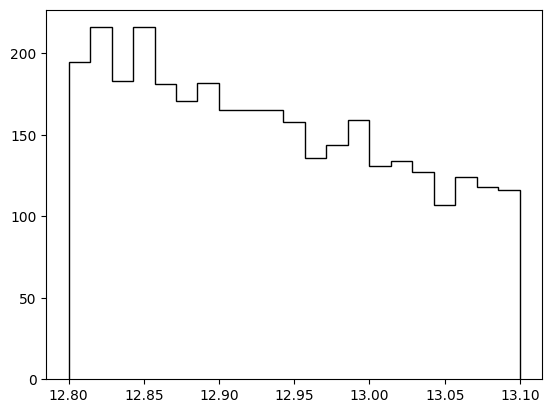

In [96]:
# double check
gmass = [t['Group_M_TopHat200'][-1] for t in trees]
plt.hist(gmass, bins=21, histtype='step', color='k', label='gmass');


In [97]:
# # now we need to match with catalog
# # let us check 1 halo
# halo_idx = trees[0]['IndexInHaloTable'][-1]
# mvir = cat["Mvir"].to_numpy()[halo_idx]
# gmass = trees[0]['Group_M_TopHat200'][-1]
# (gmass - mvir) / gmass * 100 , mvir, gmass 


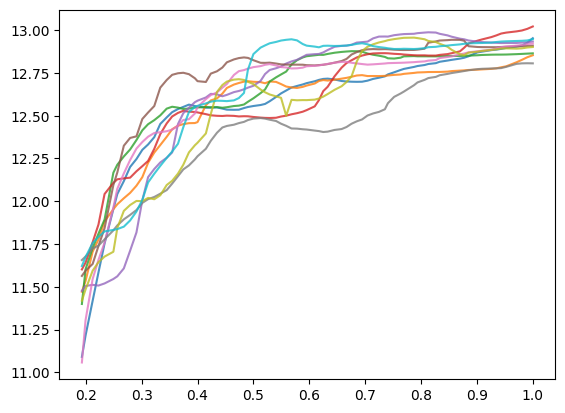

In [98]:
# plot 10 random mah as a function of scale 
for ii in range(10):
    idx = np.random.randint(0, len(trees))
    plt.plot(scales, mah[idx], '-', alpha=0.8
    );
# plt.plot(scales, mah.T, '-', alpha=0.1, c='k');


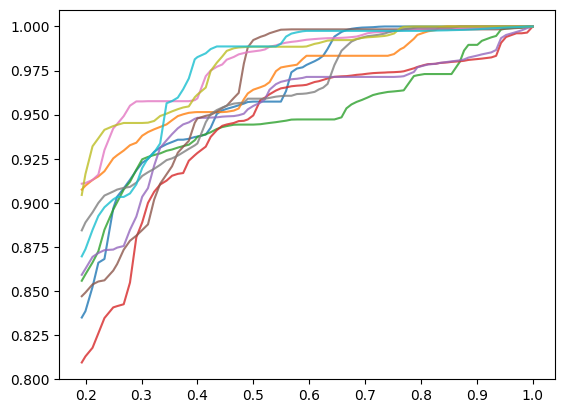

In [39]:
# plot 10 random m_peaks as a function of scale 
for ii in range(10):
    idx = np.random.randint(0, len(my_trees))
    plt.plot(_scales, m_peak[idx], '-', alpha=0.8
    );


## Create spearman correlation plots

In [41]:
exclude = ["HaloID", "SubhaloID", "SubhaloID_DMO", 'SubhaloID_LastDesc', 'Central', 'Main', 'EndState']


In [42]:
# subset pandas dataframe to indices in halo_ids
len(_cat)


4509

/var/folders/yl/5w7yl6bn1tsc5fjrdtsrsjhh0000gn/T/ipykernel_37129/2693604072.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _cat['Vmax_DM/V_vir_DM'] = _cat['Vmax_DM'] / vvir


In [41]:
# compute all spearman correlations for every quantity not in exclude
from multicam.correlations import spearmanr
corrs = {} 
for col in _cat.columns:
    if col not in exclude:
        corrs[col] = np.zeros(m_peak.shape[1]) * np.nan
        for jj in range(m_peak.shape[1]):
            corrs[col][jj] = spearmanr(_cat[col].values, m_peak[:, jj])


/Users/imendoza/Library/Caches/pypoetry/virtualenvs/multicam-P7T5KfjX-py3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [38]:
# now plot all correlations (each separately), save to png
for col in _cat.columns:
    if col not in exclude:
        plt.figure(figsize=(5, 5))
        plt.plot(_scales, corrs[col], '-', c='k')
        plt.xlabel("a")
        plt.ylabel("Spearman r")
        plt.title(col)
        plt.savefig(f"../../results/tng/figs/{col}.png", bbox_inches='tight')
        plt.close()


In [50]:
corrs['cvir'].shape


(80,)

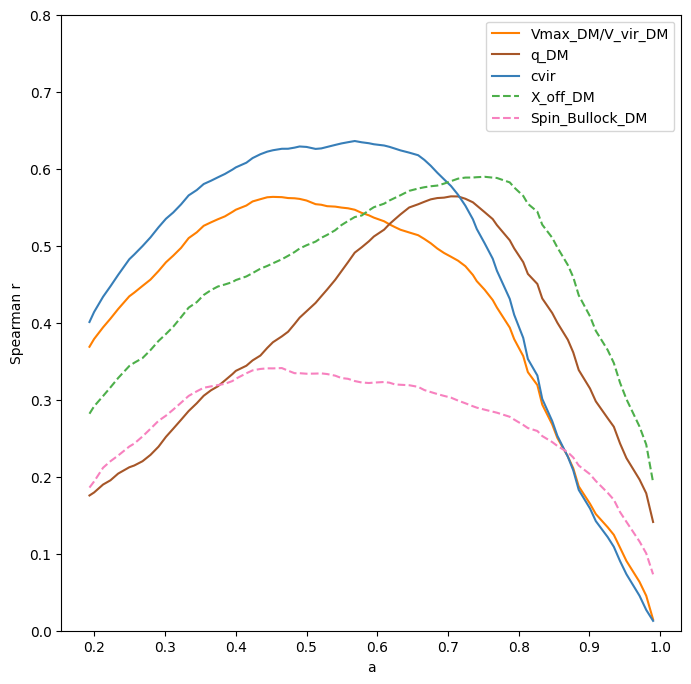

In [54]:
# now plot all correlations (separately), save to png
from multicam.plotting import CB_COLORS
colors_dict = {'cvir': CB_COLORS[0], 
               'Vmax_DM/V_vir_DM': CB_COLORS[1], 
               'X_off_DM': CB_COLORS[2], 
               'Spin_Bullock_DM': CB_COLORS[4],  
               'q_DM': CB_COLORS[5], }
params = {'cvir','Vmax_DM/V_vir_DM', 'X_off_DM', 'Spin_Bullock_DM',  'q_DM', }
assert params.issubset(set(_cat.columns))
assert params.issubset(set(corrs.keys()))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for param in params:
        sgn = (sum(corrs[param] > 0) - sum(corrs[param] < 0)) > 0
        style = '-' if sgn else '--'
        
        corr = np.abs(corrs[param])
        ax.plot(_scales, corr, style, label=param, color=colors_dict[param])
        ax.set_xlabel("a")
        ax.set_ylabel("Spearman r")
ax.set_ylim(0, 0.8)
ax.legend(loc='best')


(array([ 39.,  38.,  41.,  53.,  59.,  68.,  66.,  63.,  96.,  83.,  87.,
         96., 121., 118., 127., 127., 125., 122., 152., 145., 159., 160.,
        180., 168., 163., 169., 164., 153., 133., 129., 122., 133., 104.,
         83., 100.,  91.,  81.,  58.,  52.,  34.,  28.,  34.,  27.,  23.,
         21.,  17.,  14.,  12.,   7.,  11.,   6.,   5.,   9.,   4.,   2.,
          3.,   1.,   0.,   3.,   0.,   2.,   2.,   0.,   1.,   1.,   0.,
          1.,   0.,   3.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.,   1.]),
 array([1.00025723, 1.00687561, 1.01349399, 1.02011236, 1.02673074,
        1.03334911, 1.03996749, 1.04658586, 1.05320424, 1.05982261,
        1.06644099, 1.07305936, 1.07967774, 1.08629612, 1.09291449,
        1.09953287, 1.10615124, 1.11276962, 1.11938799, 1.12600637,
        1.13262474, 1.13924312, 1.145861

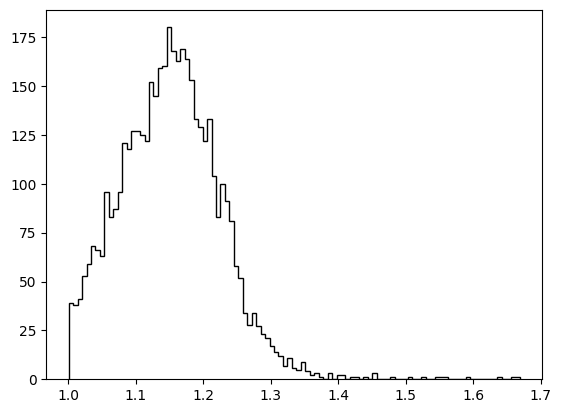

In [39]:
plt.hist(_cat['Vmax_DM/V_vir_DM'], bins=101, histtype='step', color='k')


## Mean stellar mass - halo mass relation

In [28]:
ratio = np.log10(cat['Mstar_30pkpc'] / cat['Mvir']) 
plt.hist()


0        12.144862
1        11.937503
2        12.156231
3        11.931321
4        11.999215
           ...    
13638     9.146354
13639          NaN
13640     8.643658
13641          NaN
13642          NaN
Name: Mstar_30pkpc, Length: 13643, dtype: float64